In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
import glob
import json
%matplotlib inline

## Pick images to test
There are three image sets collected from different sources, simulating three kinds of real world situations. Highway, City road, and images with or without the hood. The best models and parameters varies for each. Thus, please first pick a dataset you want to test on, and set the related global variables, $hood$ and $high$.

In [2]:
# images with hood, hood = True, else, hood = False by default
HOOD = ### 

# Highway? -> HIGH = True, else, HIGH = False by default
HIGH = ###

if HOOD:
    config = 'Config/config_00.json'  # Hood
elif HIGH:
    config = 'Config/config_02.json'  # No hood, highway
else:
    config = 'Config/config_01.json'  # No hood, city

with open(config, 'r') as config_file:
    data = json.load(config_file)

## Define Plot Function
This function is used during the pipeline building process to show the difference between the original and procsessed images.

In [3]:
def plot_images(original, modified, title):
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(original)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(modified, cmap='gray')
    ax2.set_title(title, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Read image

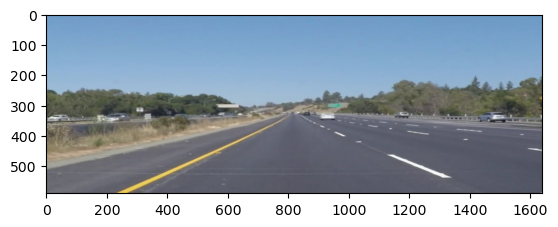

In [4]:
img = mpimg.imread('new_images/47.jpg')
img = cv2.resize(img, (1640, 590))
plt.imshow(img)

## Thresholding

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel = 3, thresh = (0,255)):
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output


# Define a function to threshold an image for a given range and Sobel kernel for directionsobel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output.astype(np.uint8)

#used for the white lanes histogram equalisation thresholding 
def adp_thresh_grayscale(gray, thr = 250):
    img = cv2.equalizeHist(gray)
    ret, thrs = cv2.threshold(img, thresh=thr, maxval=255, type=cv2.THRESH_BINARY)
    return thrs

#Color thresholding, takes saturation and value images in single channel and corresponding threshold values
def color_thr(s_img, l_img, s_threshold = (0,255), l_threshold = (0,255)):
    s_binary = np.zeros_like(s_img).astype(np.uint8)
    s_binary[(s_img > s_threshold[0]) & (s_img <= s_threshold[1])] = 1
    l_binary = np.zeros_like(l_img).astype(np.uint8)
    l_binary[(l_img > l_threshold[0]) & (l_img <= l_threshold[1])] = 1
    col = ((s_binary == 1) | (l_binary == 1))
    return col


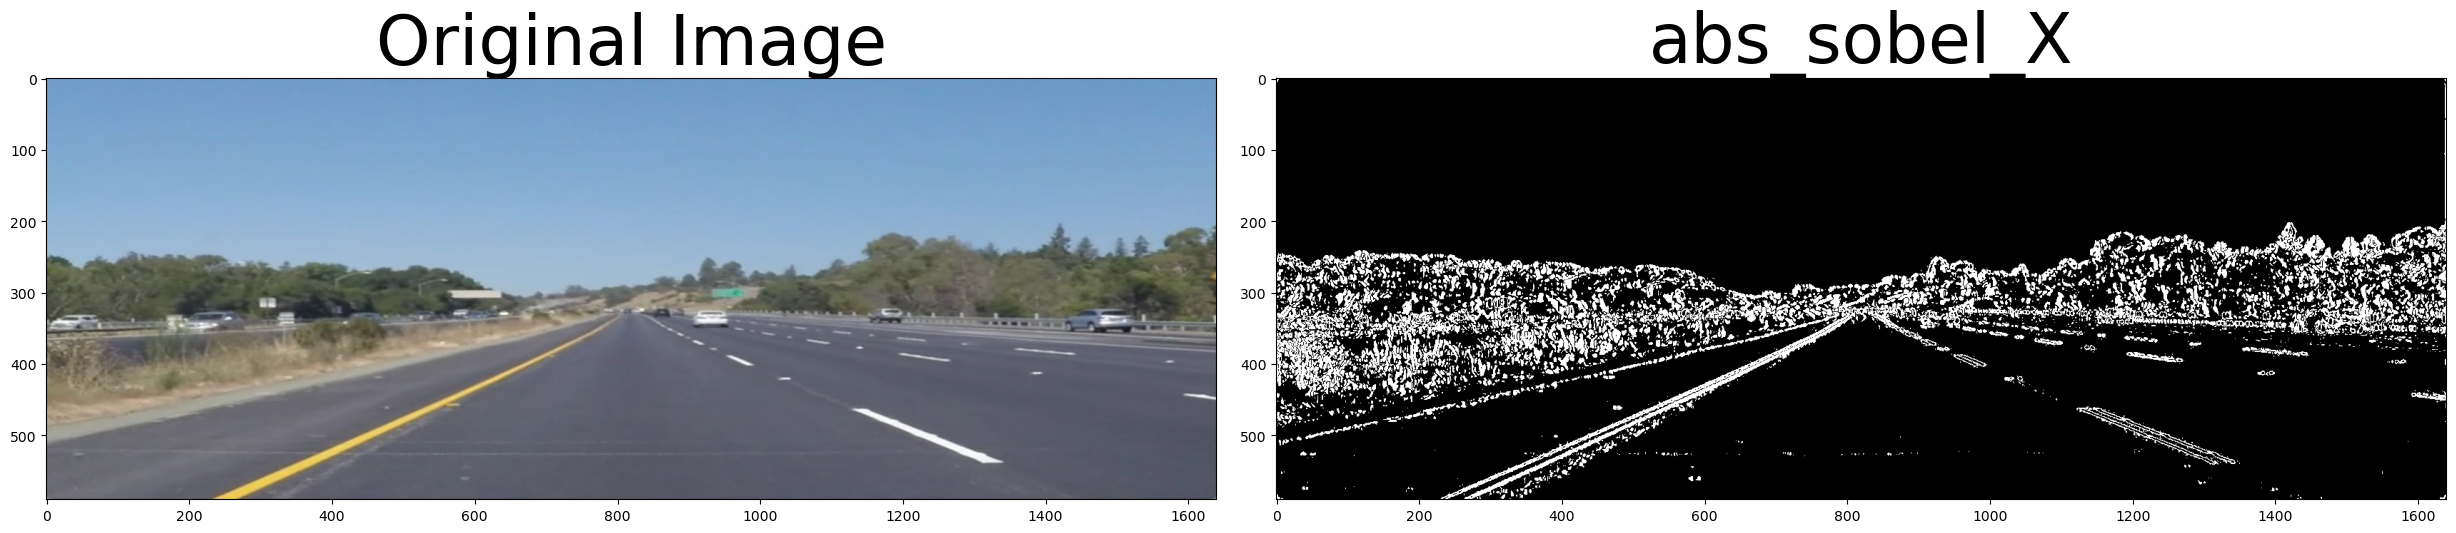

In [19]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# out_img = abs_sobel_thresh(gray, 'x', 3, (30,50))
# out_img = abs_sobel_thresh(gray, 'x', 3, (10,100))
out_img = abs_sobel_thresh(gray, 'x', 3, (10,80))

# out_img = mag_thresh(gray, 3, (20,100))
# out_img = adp_thresh_grayscale(gray,160)
plot_images(img,out_img,"abs_sobel_X")

d:\Anaconda\envs\kkkkk\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


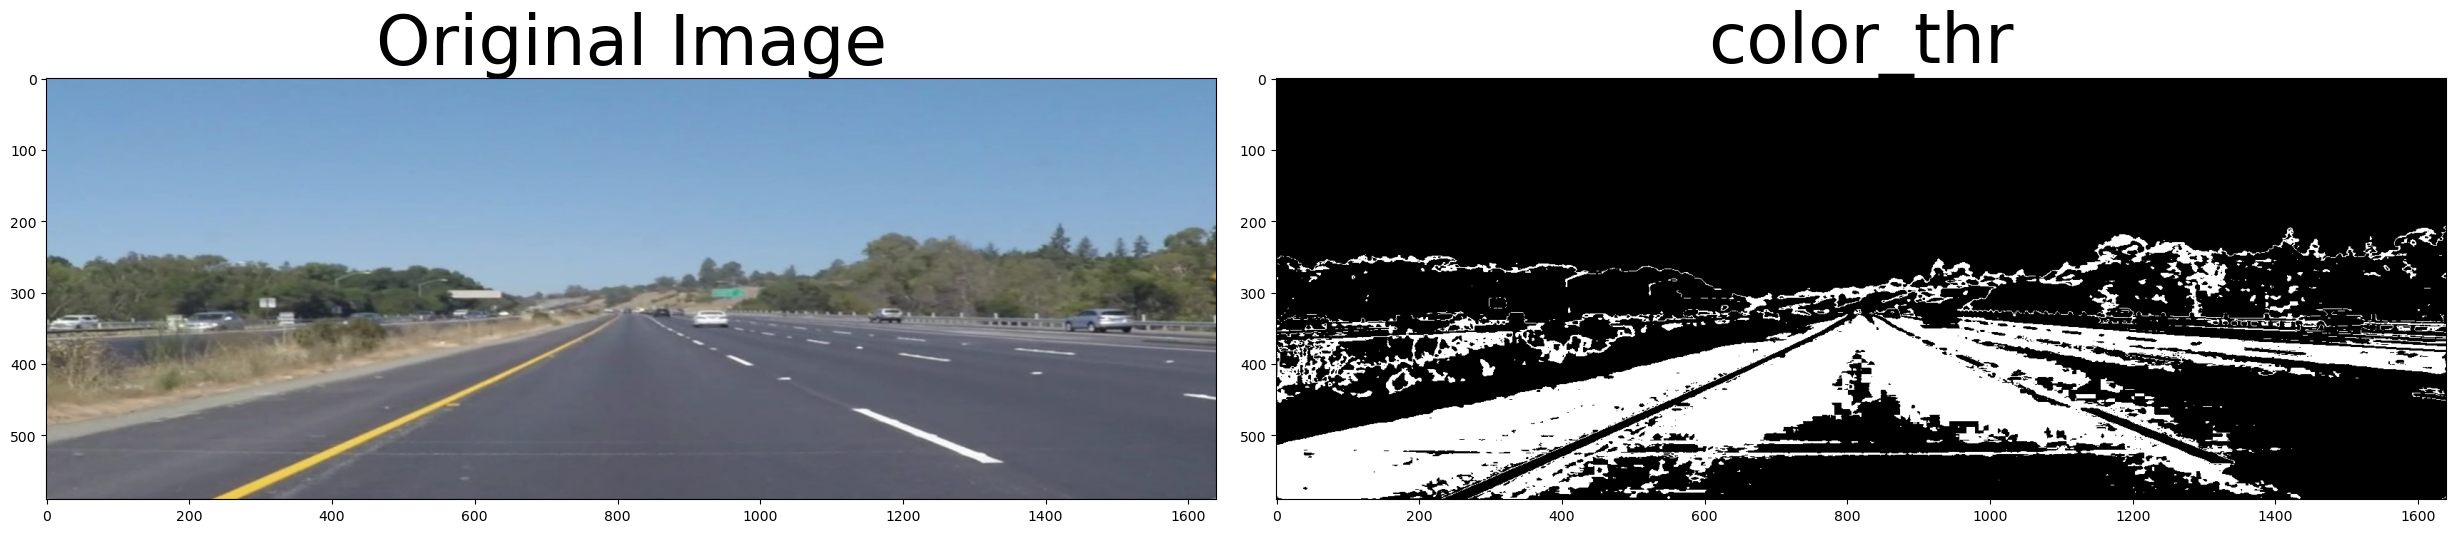

In [23]:
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
s_channel = hls[:,:,2].astype(np.uint8)
l_channel = hls[:,:,1].astype(np.uint8)
# out_img = color_thr(s_channel, l_channel,(220,255),(100,100))
out_img = color_thr(s_channel, l_channel,(20,20),(100,120))
# out_img = color_thr(s_channel, l_channel,(10,10),(100,150))
plot_images(img, out_img, "color_thr")

## Region of interest & Perspective transform

In [8]:
def perspective_transform(img, distorted=False):
    if distorted == True:
        print("The image is distorted")
        dist_pickle = pickle.load( open( "calibration_pickle.p", "rb" ) )
        mtx = dist_pickle["mtx"]
        dist = dist_pickle["dist"]
        img = cv2.undistort(img, mtx, dist, None, mtx)

    imshape = img.shape
    
    if(HOOD):
        vertices = np.array([[(.5281*imshape[1], .6586*imshape[0]), (.5619*imshape[1],.8213*imshape[0]),
        (.376*imshape[1],.8213*imshape[0]),(.4251*imshape[1], .6586*imshape[0])]], dtype=np.float32)
        
        src = np.float32(vertices)
        dst = np.array([[(.5281*imshape[1], .6586*imshape[0]), (.5281*imshape[1],.8213*imshape[0]),
        (.376*imshape[1],.8213*imshape[0]),(.376*imshape[1], .6586*imshape[0])]], dtype=np.float32)
    
    else:
        xoffset = 0
        yoffset = 0
        img_size = (imshape[1], imshape[0]) 
        
        if(not HIGH):
            src = np.float32([(650, 420), (1000,420), (1500, 700), (100, 700)])
            dst = np.float32([[xoffset, yoffset], [img_size[0]-xoffset, yoffset], 
                                        [img_size[0]-xoffset, img_size[1]-yoffset], 
                                        [xoffset, img_size[1]-yoffset]])
            
        else:
            src = np.float32([(700,350), (900,350), (2000, 700), (50, 700)])
            dst = np.float32([[xoffset, yoffset], [img_size[0]-xoffset, yoffset], 
                                        [(img_size[0]-xoffset)*3/4, img_size[1]-yoffset], 
                                        [(img_size[0]-xoffset)*1/4, img_size[1]-yoffset]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    img_size = (imshape[1], imshape[0]) 
    perspective_img = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)
    return perspective_img, Minv

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img, dtype=np.uint8)
    if len(img.shape) > 2:
        channel_count = img.shape[2]  #  depending on out image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255  
    masked_image = cv2.fillPoly(mask, vertices, ignore_mask_color)
    mask=cv2.imread(r"mask.png")
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

## Pipeline thresholding and finding region of interest

In [9]:
# import json
# with open(r'Config/config_00.JSON') as config_file:
#         data = json.load(config_file)

grad_thx_mins=data['grad_thx_min']
grad_thx_maxs=data['grad_thx_max']
grad_thy_mins=data['grad_thy_min']
grad_thy_maxs=data['grad_thy_max']
mag_th_mins=data['mag_th_min']
mag_th_maxs=data['mag_th_max']
dir_th_mins=data['dir_th_min']
dir_th_maxs=data['dir_th_max']
s_threshold_mins=data['s_threshold_min']
s_threshold_maxs=data['s_threshold_max']
l_threshold_mins=data['l_threshold_min']
l_threshold_maxs=data['l_threshold_max']
k_sizes=data['k_size']
adp_thrs=data['adp_thr']

def thresholding(img, grad_thx_min =grad_thx_mins, grad_thx_max =grad_thx_maxs,
                 grad_thy_min =grad_thy_mins, grad_thy_max = grad_thy_maxs, mag_th_min = mag_th_mins,
                 mag_th_max = mag_th_maxs, dir_th_min  =dir_th_mins, dir_th_max = dir_th_maxs, 
                 s_threshold_min = s_threshold_mins, s_threshold_max = s_threshold_maxs, 
                 l_threshold_min = l_threshold_mins, l_threshold_max = l_threshold_maxs,  k_size = k_sizes, 
                 adp_thr = adp_thrs):
    imshape = img.shape
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2].astype(np.uint8)
    l_channel = hls[:,:,1].astype(np.uint8)
    ksize = k_size 
    gradx = abs_sobel_thresh(l_channel, orient='x', sobel_kernel=ksize, thresh=(grad_thx_min,grad_thx_max))
    grady = abs_sobel_thresh(l_channel, orient='y', sobel_kernel=ksize, thresh=(grad_thy_min, grad_thy_max))
    mag_binary = mag_thresh(l_channel, sobel_kernel=ksize, mag_thresh=(mag_th_min, mag_th_max))
    dir_binary = dir_threshold(l_channel, sobel_kernel=ksize, thresh=(dir_th_min, dir_th_max))
    combined = np.zeros_like(gradx)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    s_binary = color_thr(s_channel, l_channel, s_threshold=(s_threshold_min,s_threshold_max), 
                         l_threshold= (l_threshold_min,l_threshold_max)).astype(np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    adp = adp_thresh_grayscale(gray, adp_thr)/255
    color_binary = np.zeros_like(gradx)
    
    if(HOOD):
        color_binary[(combined == 1) | (s_binary == 1) | (adp == 1)] = 1
    else:
        color_binary[(combined == 1) | (adp == 1) & (s_binary == 1) ] = 1 
    color_binary = np.dstack(( color_binary,color_binary,color_binary)).astype(np.float32)
    
    if(HOOD):
        vertices = np.array([[(.4*imshape[1], .4*imshape[0]), (.6*imshape[1],.4*imshape[0]),
                        (.8*imshape[1],imshape[0]),(.23*imshape[1], imshape[0])]], dtype=np.int32)
        color_binary = region_of_interest(color_binary.astype(np.uint8), vertices)

    return color_binary.astype(np.float32), combined, s_binary

d:\Anaconda\envs\kkkkk\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


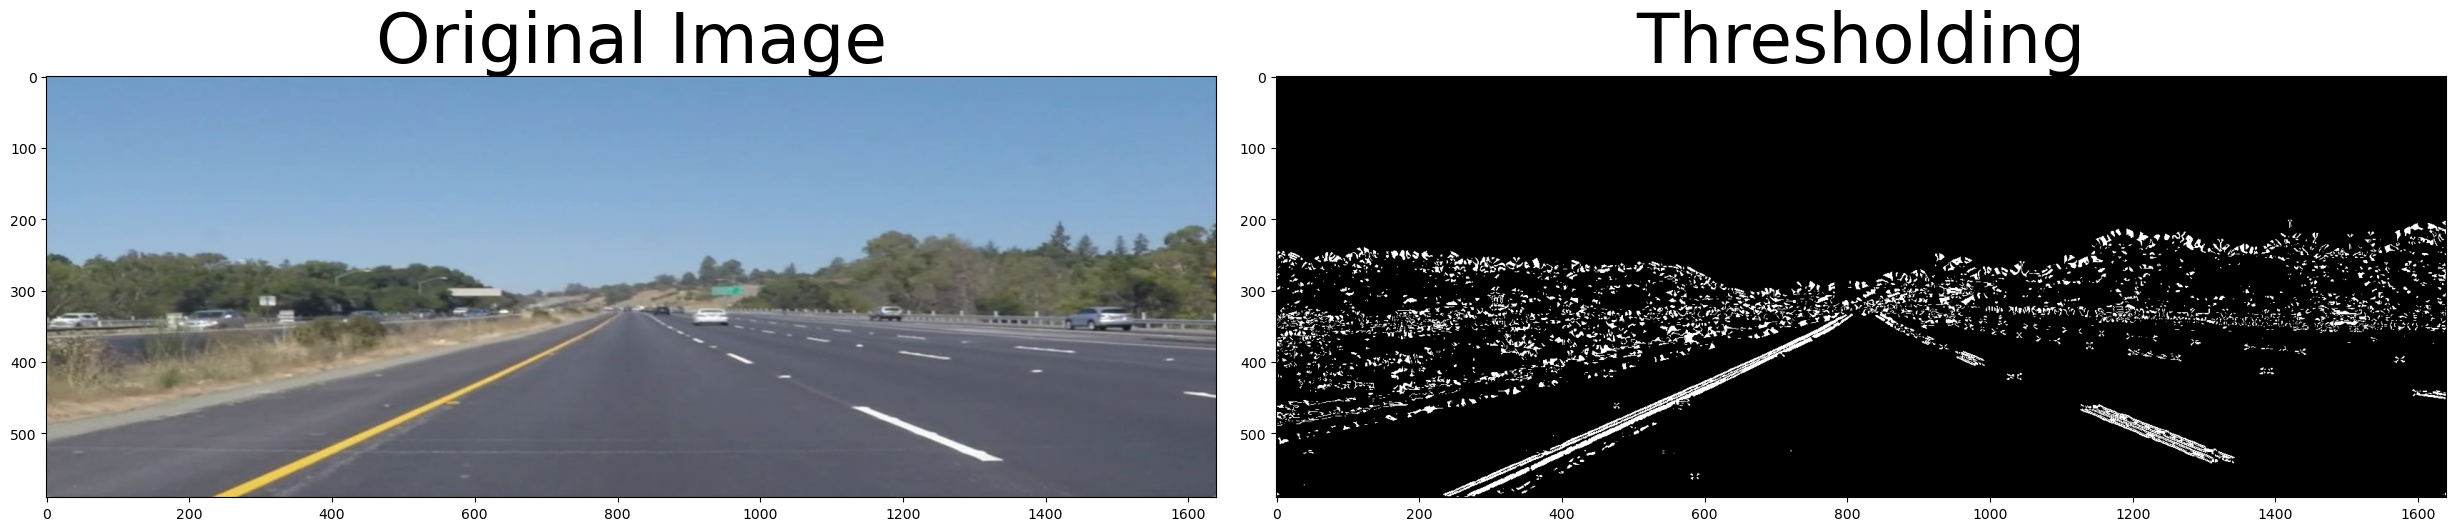

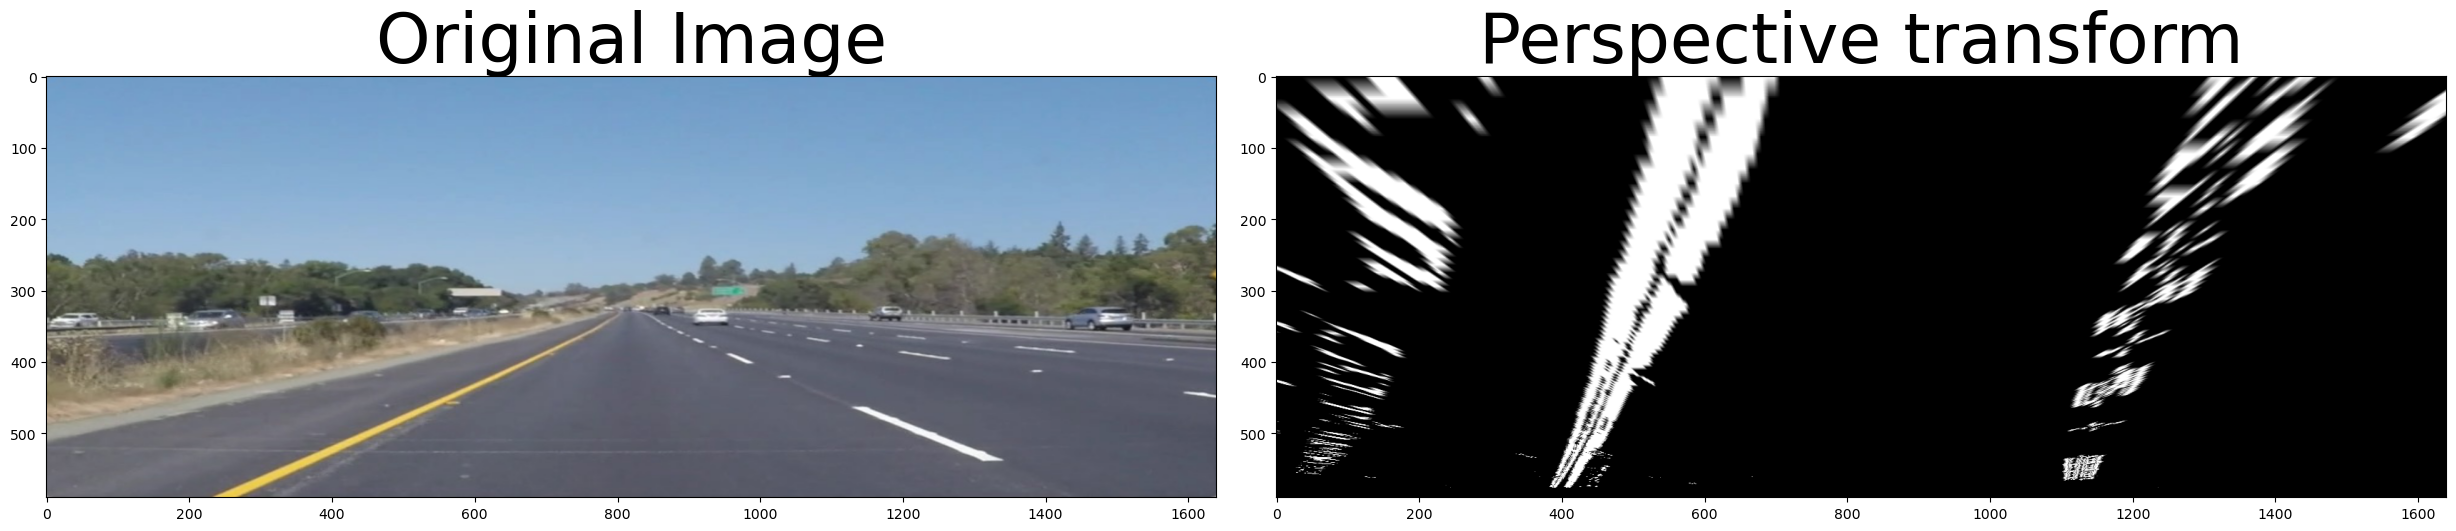

In [20]:
thresh_combined, grad_th, col_th = thresholding(img)  
perspective, Minv = perspective_transform(thresh_combined)
plot_images(img, thresh_combined, "Thresholding")
plot_images(img, perspective, "Perspective transform")

## Helper function

In [12]:
import numpy as np

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = np.zeros(590)  
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = np.zeros(3)  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = np.zeros(1)
        #distance in meters of vehicle center from the line
        self.line_base_pos = np.zeros(1)
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #smoothen the n frames 
        self.smoothen_nframes = 10
        #first frame 
        self.first_frame = True


left_lane = Line()
right_lane = Line()

def init_lines(width):
    global left_lane
    left_lane.bestx = np.zeros(width)
    # was the line detected in the last iteration?
    left_lane.detected = False
    # x values of the last n fits of the line
    left_lane.recent_xfitted = []
    # polynomial coefficients averaged over the last n iterations
    left_lane.best_fit = np.zeros(3)
    # polynomial coefficients for the most recent fit
    left_lane.current_fit = [np.array([False])]
    # radius of curvature of the line in some units
    left_lane.radius_of_curvature = np.zeros(1)
    # distance in meters of vehicle center from the line
    left_lane.line_base_pos = np.zeros(1)
    # difference in fit coefficients between last and new fits
    left_lane.diffs = np.array([0, 0, 0], dtype='float')
    # x values for detected line pixels
    left_lane.allx = None
    # y values for detected line pixels
    left_lane.ally = None
    # smoothen the n frames
    left_lane.smoothen_nframes = 10
    # first frame
    left_lane.first_frame = True

    global right_lane
    right_lane.bestx = np.zeros(width)
    # was the line detected in the last iteration?
    right_lane.detected = False
    # x values of the last n fits of the line
    right_lane.recent_xfitted = []
    # polynomial coefficients averaged over the last n iterations
    right_lane.best_fit = np.zeros(3)
    # polynomial coefficients for the most recent fit
    right_lane.current_fit = [np.array([False])]
    # radius of curvature of the line in some units
    right_lane.radius_of_curvature = np.zeros(1)
    # distance in meters of vehicle center from the line
    right_lane.line_base_pos = np.zeros(1)
    # difference in fit coefficients between last and new fits
    right_lane.diffs = np.array([0, 0, 0], dtype='float')
    # x values for detected line pixels
    right_lane.allx = None
    # y values for detected line pixels
    right_lane.ally = None
    # smoothen the n frames
    right_lane.smoothen_nframes = 10
    # first frame
    right_lane.first_frame = True

## Sliding window to fit the line

In [13]:
def for_sliding_window(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 15
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 75
    # Set minimum number of pixels found to recenter window
    minpix = 100
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    #check for any lanes that are not detected in this current frame then use the history
    if (leftx.size < 5):
        left_lane.detected = False
        #print ("Left lane deteceted - False")
    else:
        left_lane.detected = True
        #print ("Left lane detected - true")
    
    if (rightx.size < 5):
        right_lane.detected = False
        #print ("Right lane detected False")
    else:
        right_lane.detected = True
        #print ("Right lane detected True")
        
    #print (left_lane.detected, right_lane.detected)
    #if lane is detected then try to fit the poly
    if left_lane.detected == True & right_lane.detected == True:
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        left_lane.best_fit = np.vstack([left_lane.best_fit,left_fit])
        left_lane.best_fit[0] = left_fit
        right_lane.best_fit = np.vstack([right_lane.best_fit,right_fit])
        right_lane.best_fit[0] = right_fit
        left_lane.best_fit = np.average(left_lane.best_fit[-left_lane.smoothen_nframes:], axis = 0)
        right_lane.best_fit = np.average(right_lane.best_fit[-right_lane.smoothen_nframes:], axis = 0)
        #print ("saved best fit")
    else: 
        #use the history avg values 
        left_fit = left_lane.best_fit
        right_fit = right_lane.best_fit
        #print ("used previous best fit")
    #calculate the actual points in x and y is from 0 to 589
    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    #print (left_lane.first_frame)
    #Take the average here of the last n frames   
    if left_lane.first_frame == True:
        left_lane.first_frame = False
        left_lane.bestx = np.vstack([left_lane.bestx,left_fitx])
        left_lane.bestx[0] = left_fitx
        #print ("Inside first frame")

    if ((left_fitx[0] > right_fitx[0]) | (abs(left_fitx[0] - right_fitx[0])<350) | (abs(left_fitx[0] - right_fitx[0])>700) |
                   (left_fitx[0] > 1640 )):
        left_lane.bestx = np.vstack([left_lane.bestx,left_lane.bestx])  
        #print ("Skip lane left")
    else:
        left_lane.bestx = np.vstack([left_lane.bestx,left_fitx])
        #print ("read lane left")
        
    left_lane.bestx = np.average(left_lane.bestx[-left_lane.smoothen_nframes:], axis = 0)
    
    if right_lane.first_frame == True:
        right_lane.first_frame = False
        right_lane.bestx = np.vstack([right_lane.bestx,right_fitx])
        right_lane.bestx[0] = right_fitx
        #print ("Inside first frame")

    if ((left_fitx[0] > right_fitx[0]) | (abs(left_fitx[0] - right_fitx[0])<350) | (abs(left_fitx[0] - right_fitx[0])>700) |
                      (right_fitx[0] > 1640)):
        right_lane.bestx = np.vstack([right_lane.bestx,right_lane.bestx])
        #print ("Skip lane right")
    else:
        right_lane.bestx = np.vstack([right_lane.bestx,right_fitx])
        #print ("read lane right")
    
    right_lane.bestx = np.average(right_lane.bestx[-right_lane.smoothen_nframes:], axis = 0)
    
    #print (left_lane.bestx[0])
    #print (left_fitx[0])
    #print (right_lane.bestx[0])
    #print (right_fitx[0])

    
    window_img = np.zeros_like(out_img)
    margin = 15
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 255]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 0, 255]
    # Generate a polygon to illustrate the SMOOTHENED FIT
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_lane.bestx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_lane.bestx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_lane.bestx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_lane.bestx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 1, 0)
    
    # Generate a polygon to illustrate the CURRENT FRAME FIT
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,0, 255))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,0, 255))
    result = cv2.addWeighted(out_img, 1, window_img, 1, 0)


    if (leftx.size > 2 | rightx.size > 2) :
        y_eval = np.max(ploty)
        # Define conversions in x and y from pixels space to meters
        # ym_per_pix = 30/720 # meters per pixel in y dimension
        ym_per_pix = 16 / binary_warped.shape[0]
        xm_per_pix = 3.7/590 # meters per pixel in x dimension was 700

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters and dist from centre
        lane_centre = (left_fitx[-1] + right_fitx[-1])/2.0
        camera_centre = result.shape[1]/2.0
 
        dist_centre_val = (lane_centre - camera_centre)*3.7/400 # was 700
        avg_cur = (right_curverad+left_curverad)/2.0
        
        left_lane.line_base_pos = np.vstack([left_lane.line_base_pos,dist_centre_val])
        left_lane.line_base_pos[0] = dist_centre_val
        left_lane.line_base_pos = np.average(left_lane.line_base_pos[-left_lane.smoothen_nframes:], axis = 0)
        
        left_lane.radius_of_curvature = np.vstack([left_lane.radius_of_curvature,avg_cur])
        left_lane.radius_of_curvature[0] = avg_cur
        left_lane.radius_of_curvature = np.average(left_lane.radius_of_curvature[-left_lane.smoothen_nframes:], axis = 0)
        
    #print (avg_cur, dist_centre_val)
    # else use the history curvature
    else:
        dist_centre_val = left_lane.line_base_pos
        avg_cur = left_lane.radius_of_curvature
    
    #reset the lane detected to false for the next frame 
    left_lane.detected == False
    right_lane.detected == False
    return result, left_lane.bestx, right_lane.bestx, ploty, left_lane.radius_of_curvature, left_lane.line_base_pos

## Draw lane on original image

In [14]:
def draw_on_original(undist, left_fitx, right_fitx, ploty, Minv):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(undist).astype(np.uint8)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane with low confidence region in yollow
    cv2.fillPoly(color_warp, np.int_([pts]), (255, 255,0))
    # confidence region in green
    start_width = int(undist.shape[0] * 55.5 / 100.0)
    pts_left = np.array([np.transpose(np.vstack([left_fitx[start_width:], ploty[start_width:]]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx[start_width:], ploty[start_width:]])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 0, 255))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.4, 0)
    return result

def draw_on_original_Left(undist,  left_fitx, ploty, Minv):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(undist).astype(np.uint8)
    # confidence region in green
    start_width = int(30)
    pts_left = np.array([np.transpose(np.vstack([left_fitx[start_width:], ploty[start_width:]]))])
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts_left]), (255, 255, 255))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    global newwarp1
    newwarp1 = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))
    # Combine the result with the original image
    return newwarp1

def draw_on_original_Right(undist,  right_fitx, ploty, Minv):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(undist).astype(np.uint8)
    # confidence region in green
    start_width = int(30)
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx[start_width:], ploty[start_width:]])))])
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts_right]), (255, 255, 255))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    global newwarp
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0]))
    # Combine the result with the original image
    return newwarp

## Pipeline Everything

In [15]:
def detectLane(img):
    img = cv2.resize(img, (1640, 590))
    thresh_combined, grad_th, col_th = thresholding(img)  
    perspective, Minv = perspective_transform(thresh_combined)
    perspective = cv2.cvtColor(perspective, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    slides_pers, left_fitx, right_fitx, ploty, avg_cur, dist_centre_val = for_sliding_window(perspective)
    plot_images(img, slides_pers,"Sliding windows")
    mapped_lane = draw_on_original(img, left_fitx, right_fitx, ploty, Minv)
    L=draw_on_original_Left(img, left_fitx, ploty, Minv)
    R=draw_on_original_Right(img, right_fitx, ploty, Minv)
    L=cv2.resize(L, (800,288))
    R=cv2.resize(R, (800,288))
    return mapped_lane

## Result

d:\Anaconda\envs\kkkkk\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
d:\Anaconda\envs\kkkkk\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 

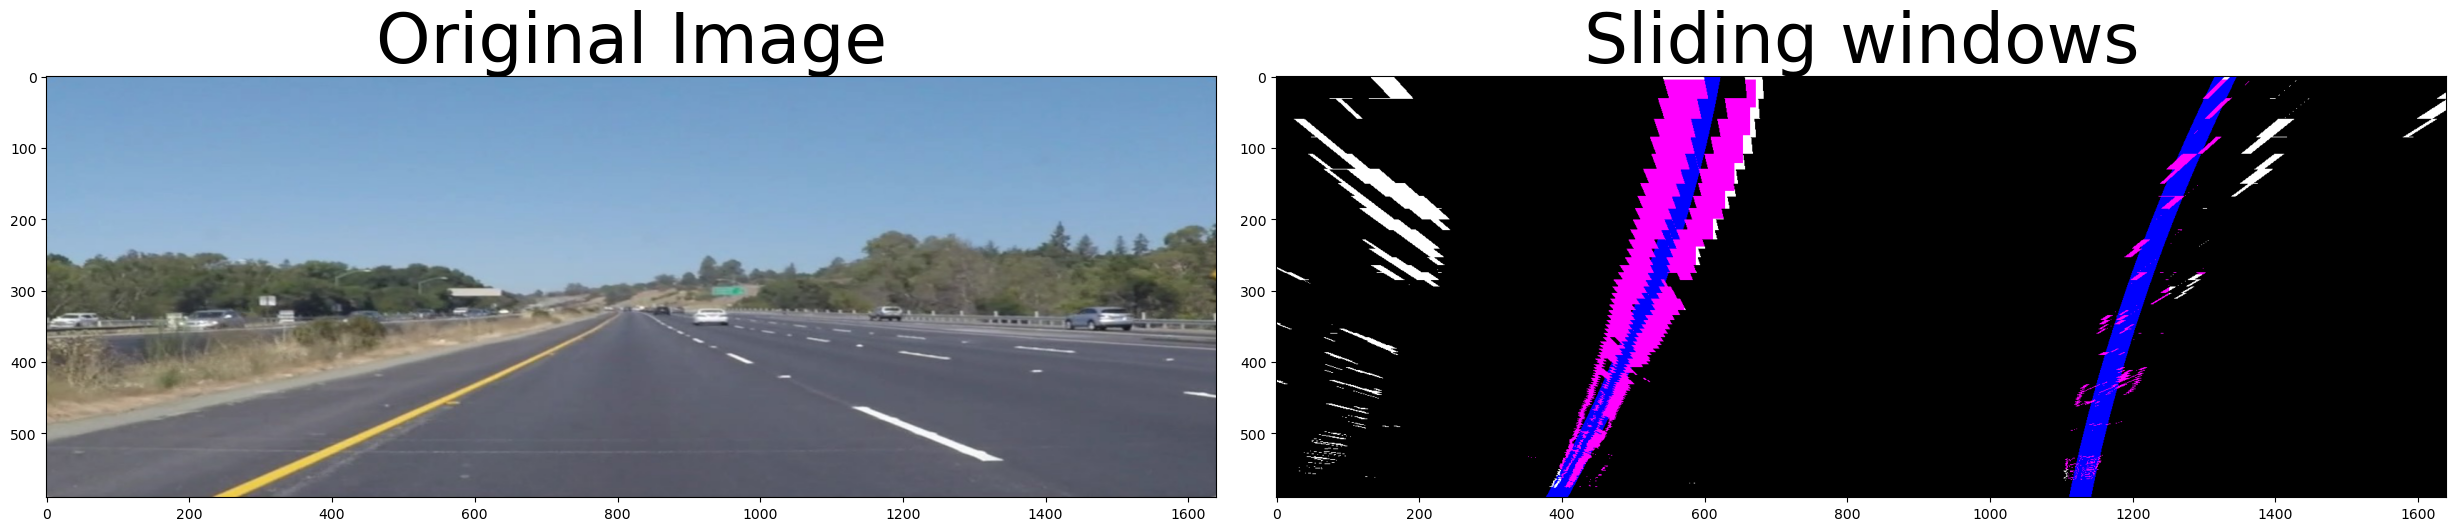

In [16]:
output = detectLane(img)

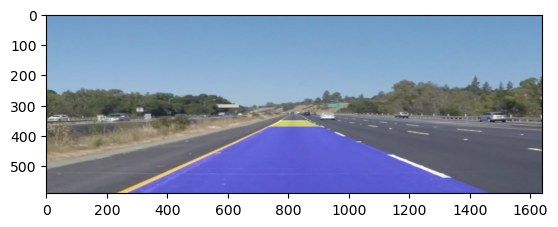

In [17]:
plt.imshow(output)